In [1]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import netCDF4
import numpy as np
import pandas as pd
import scipy.spatial
import trimesh

from DDV import eigenbasis, sph_utils, kernel

C:\Users\mg874\anaconda3\Lib\site-packages\tqdm_joblib\__init__.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
def read_data(data_handle, lons, lats, time):
    u = data_handle.variables['u'][time].data
    v = data_handle.variables['v'][time].data
    df = pd.DataFrame({
        "lon": lons.flatten(),
        "lat": lats.flatten(),
        "u": u.flatten(),
        "v": v.flatten(),
    })
    return df

In [3]:
data = netCDF4.Dataset('../data/07-2020-500hpa-uv.nc', 'r')

lons = data.variables['longitude'][:].data
lats = data.variables['latitude'][:].data
lon_mesh, lat_mesh = np.meshgrid(lons, lats)

df = read_data(data, lon_mesh, lat_mesh, 0)

lat_lim = 90

df_prefilter = df[np.abs(df['lat']) < lat_lim]

In [4]:
df_filter2 = df_prefilter[(df_prefilter['lat'] % 2 == 0) & (df_prefilter['lon'] % 2 == 0)]

In [5]:
df_filternot10 = df_filter2[(df_filter2['lat'] % 10 != 0) | (df_filter2['lon'] % 10 != 0)]
df_filterfilter10 = df_filter2[(df_filter2['lat'] % 10 == 0) & (df_filter2['lon'] % 10 == 0)]
pointsnot10 = sph_utils.conv_lat_lon(df_filternot10['lat'].to_numpy(), df_filternot10['lon'].to_numpy(), 1)
points10 = sph_utils.conv_lat_lon(df_filterfilter10['lat'].to_numpy(), df_filterfilter10['lon'].to_numpy(), 1)

# artifical north- and south-pole points
points_aug_n = np.array([[0, 0, 1]])
points_aug_s = np.array([[0, 0, -1]])

all_points = np.concatenate((points10, pointsnot10, points_aug_n, points_aug_s))

all_ch = scipy.spatial.ConvexHull(all_points)

all_mesh = trimesh.Trimesh(all_ch.points, all_ch.simplices)

In [7]:
obs_vecs = sph_utils.project_to_xyz(points10, df_filterfilter10['u'].to_numpy(), df_filterfilter10['v'].to_numpy())

obs_vecs_mean_norm = np.mean(np.linalg.norm(obs_vecs, axis=1))

obs_vecs /= obs_vecs_mean_norm

pred_vecs = sph_utils.project_to_xyz(pointsnot10, df_filternot10['u'].to_numpy(),
                                     df_filternot10['v'].to_numpy()) / obs_vecs_mean_norm

sph_obs_idx = range(len(points10))
sph_pred_idx = range(len(points10), len(points10) + len(pointsnot10))

In [8]:
sphere_eigen_val, sphere_eigen_vec_d, sphere_eigen_vec_c, vol, sph_c = eigenbasis.generate_vector_basis(
    all_mesh.vertices, all_mesh.faces, depth=500)

C:\Users\mg874\anaconda3\Lib\site-packages\pydec\dec\simplicial_complex.py:177: RuntimeWarning: divide by zero encountered in divide
  data.star_inv = sparse.spdiags([1.0/stardiag],[0], N, N, format='csr')
Processing eigenvectors:   0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [9]:
# Parameters for inference
params = {
    "k_d": 1,
    "k_c": 10,
    "s_d": 0,
    "s_c": 1,
    "v": 1.5
}

In [10]:
post_mean, _ = kernel.predict_vectors(sphere_eigen_val, sphere_eigen_vec_d, sphere_eigen_vec_c, sph_obs_idx,
                                      sph_pred_idx, obs_vecs, 3, params, vol, tau=1e-4, cov=False)

Condition number of K_vec_x_x: 1.04e+07


In [11]:
z_pred_sph_re = post_mean.reshape(-1, 3)

z_all = np.zeros(all_points.shape)
z_all[sph_obs_idx] = obs_vecs
z_all[sph_pred_idx] = z_pred_sph_re

t_all = np.zeros(all_points.shape)
t_all[sph_obs_idx] = obs_vecs
t_all[sph_pred_idx] = pred_vecs

print("MSE(-ish): " + str(np.mean(np.linalg.norm(pred_vecs - z_pred_sph_re, axis=1) ** 2)))

print(
    "MSE(-ish) mag: " + str(np.mean((np.linalg.norm(pred_vecs, axis=1) - np.linalg.norm(z_pred_sph_re, axis=1)) ** 2)))
angles = np.arccos(np.clip(np.einsum('ij,ij->i', z_pred_sph_re, pred_vecs) / (
            np.linalg.norm(z_pred_sph_re, axis=1) * np.linalg.norm(pred_vecs, axis=1)), -1.0, 1.0))

print("MSE(-ish) ang: " + str(np.mean(angles)))

MSE(-ish): 0.02883704244774412
MSE(-ish) mag: 0.017430392944050965
MSE(-ish) ang: 0.17240861242673358


Processing eigenvectors:   0%|          | 0/500 [01:36<?, ?it/s]


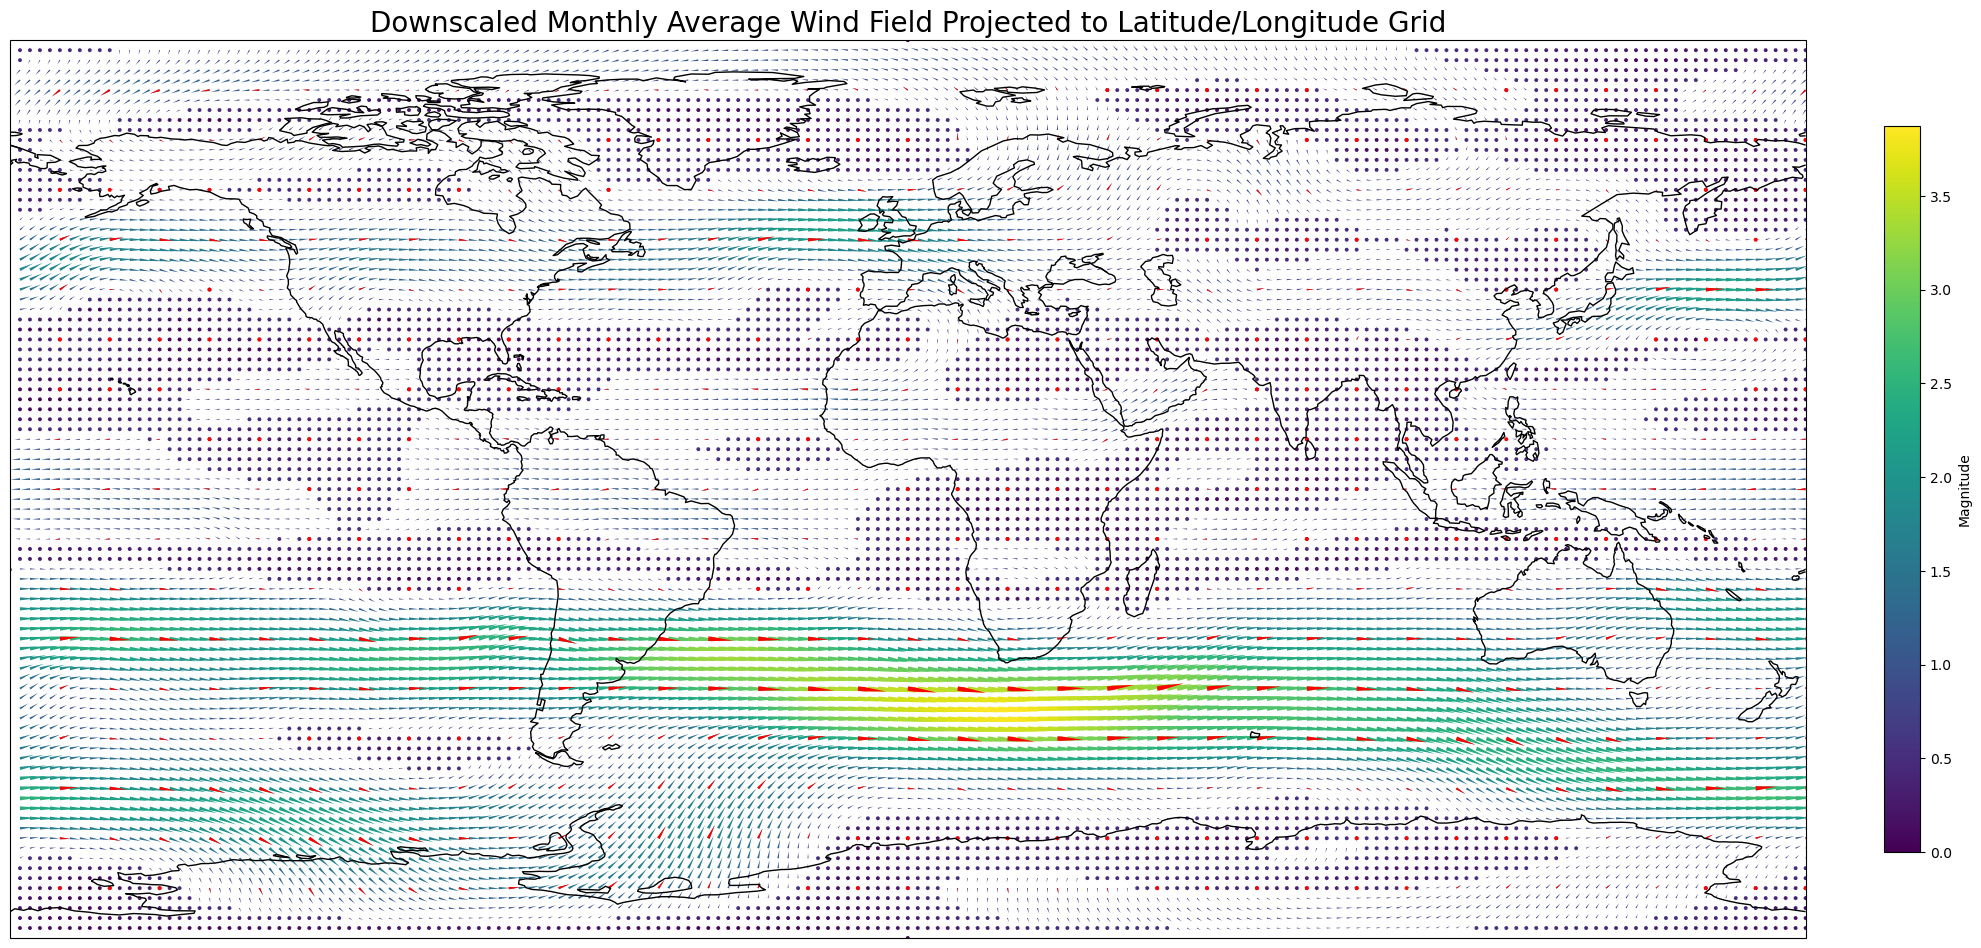

In [12]:
plat, plon, d_us, d_vs = sph_utils.project_to_latlon(all_points, z_all)

fig = plt.figure(figsize=(20, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

quiv = ax.quiver(plon, plat, d_us, d_vs, np.sqrt(np.power(d_us, 2) + np.power(d_vs, 2)), transform=ccrs.PlateCarree(),
                 headwidth=1)
quiv._init()
quiv2 = ax.quiver(plon[sph_obs_idx], plat[sph_obs_idx], d_us[sph_obs_idx], d_vs[sph_obs_idx], color='red',
                  transform=ccrs.PlateCarree(), headwidth=1, scale=quiv.scale)
plt.colorbar(mappable=quiv, label='Magnitude', fraction=0.04, pad=0.04, shrink=0.75)
plt.title('Downscaled Monthly Average Wind Field Projected to Latitude/Longitude Grid', fontsize=20)
plt.tight_layout()
# plt.show()
plt.savefig('plots/downscaled-wind.png', dpi=400)

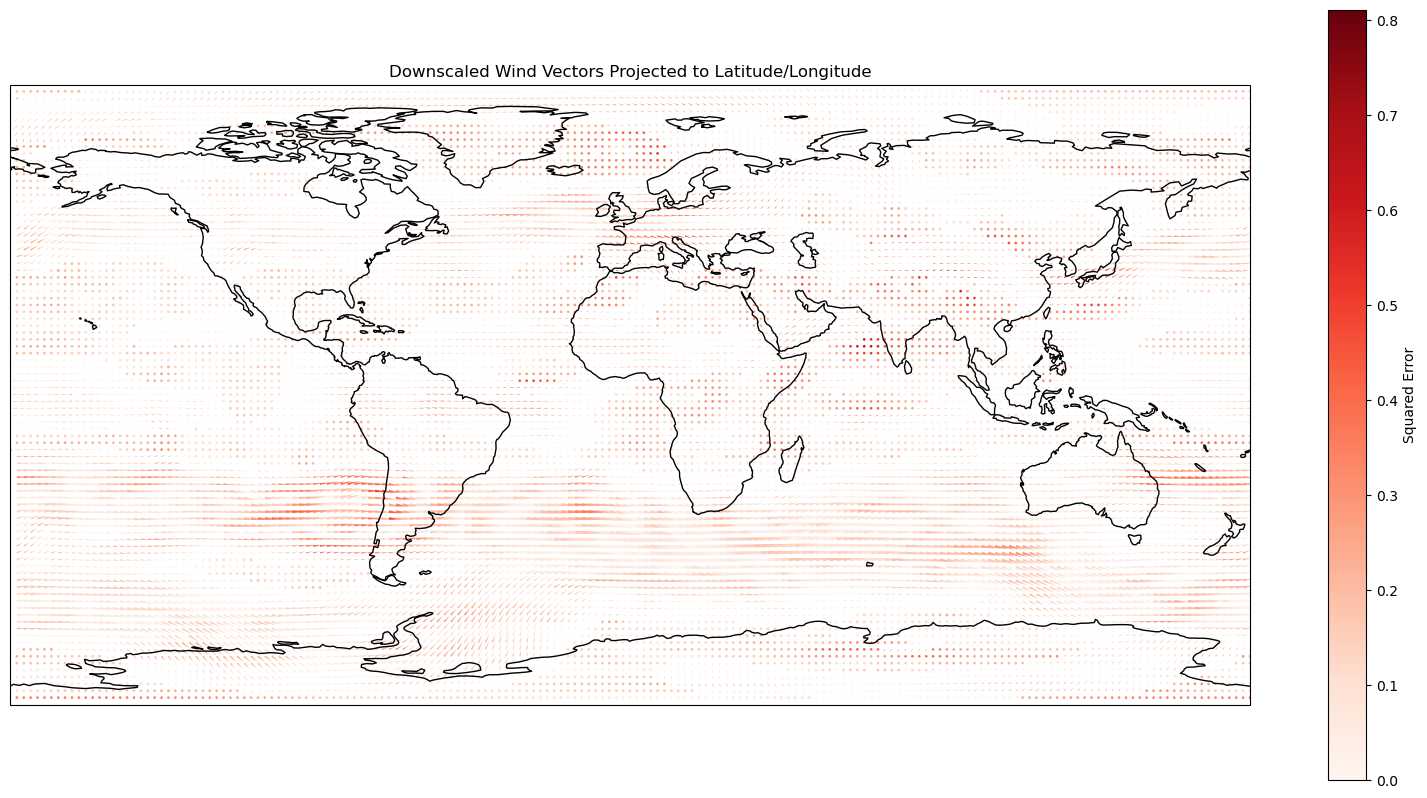

In [19]:
fig = plt.figure(figsize=(20, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
err_quiv = ax.quiver(plon, plat, d_us, d_vs, np.linalg.norm(t_all - z_all, axis=1), cmap='Reds',
                     transform=ccrs.PlateCarree(), headwidth=1)
plt.colorbar(mappable=err_quiv, label='Squared Error')
plt.title('Downscaled Wind Vectors Projected to Latitude/Longitude')
plt.show()

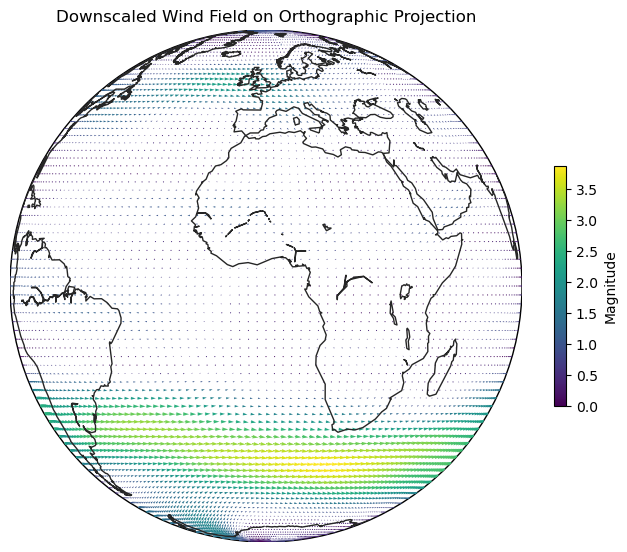

In [14]:
from mpl_toolkits.basemap import Basemap

m = Basemap(resolution='c', projection='ortho', lat_0=-0., lon_0=-0.)

fig = plt.figure(figsize=(8, 10))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

x, y = m(plon, plat)

# m.drawmapboundary(fill_color='black')
# m.fillcontinents(color='tan', lake_color='lightseagreen', zorder = 0)
m.drawcoastlines(color='0.15')

qq = m.quiver(x, y, d_us, d_vs, np.sqrt(np.power(d_us, 2) + np.power(d_vs, 2)), cmap='viridis')

plt.colorbar(qq, label='Magnitude', shrink=0.3)

plt.title("Downscaled Wind Field on Orthographic Projection")

plt.show()